# [**Visualisation du comportement de la validation croisée dans scikit-learn**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/3_model_selection/plot_cv_indices.ipynb)<br/>([_Visualizing cross-validation behavior in scikit-learn_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html))

Choisir le bon objet de validation croisée est un élément crucial pour ajuster correctement un modèle. Il existe de nombreuses façons de diviser les données en ensembles d'entraînement et de test afin d'éviter le surapprentissage du modèle, de normaliser le nombre de groupes dans les ensembles de test, etc.

Cet exemple visualise le comportement de plusieurs objets scikit-learn courants à des fins de comparaison.

In [1]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Visualiser nos données

Nous devons d'abord comprendre la structure de nos données. Il y a 100 points de données d'entrée générés aléatoirement, 3 classes réparties de manière inégale entre les points de données et 10 "groupes" répartis uniformément entre les points de données.

Comme nous le verrons, certains objets de validation croisée font des choses spécifiques avec des données étiquetées, d'autres se comportent différemment avec des données groupées, et d'autres n'utilisent pas ces informations.

Pour commencer, nous allons visualiser nos données.

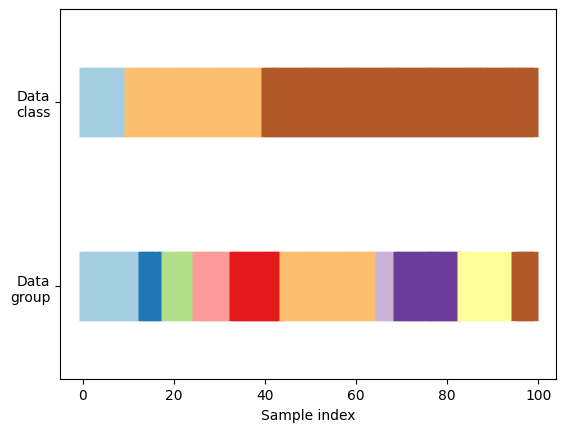

In [2]:
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

# Définir une fonction pour visualiser le comportement de validation croisée

Nous allons définir une fonction qui nous permet de visualiser le comportement de chaque objet de validation croisée. Nous allons effectuer 4 divisions des données. Sur chaque division, nous visualiserons les indices choisis pour l'ensemble d'entraînement (en bleu) et l'ensemble de test (en rouge).

In [4]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title(f"{type(cv).__name__}", fontsize=15)
    return ax

Voyons à quoi cela ressemble pour l'objet de validation croisée [**`KFold`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) :

<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

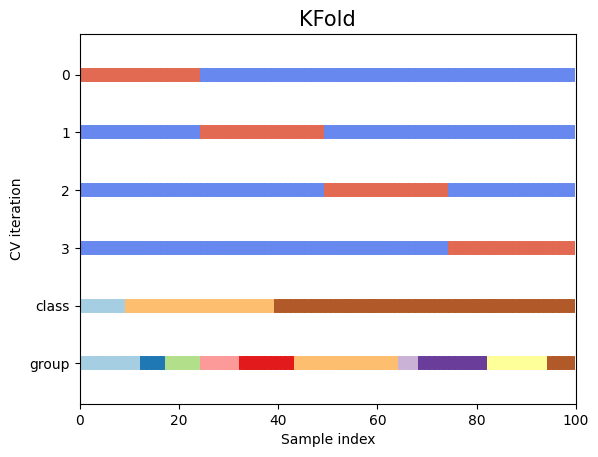

In [5]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

Comme vous pouvez le constater, par défaut, l'itérateur de validation croisée KFold ne prend en compte ni la classe ni le groupe de points de données. Nous pouvons changer cela en utilisant soit:

* `StratifiedKFold` pour conserver le pourcentage d'échantillons pour chaque classe.
* `GroupKFold` pour s'assurer que le même groupe n'apparaîtra pas dans deux plis différents.
* `StratifiedGroupKFold` pour conserver la contrainte de `GroupKFold` lors de la tentative de retour de plis stratifiés.

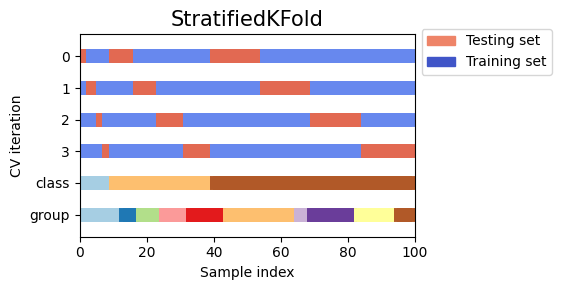

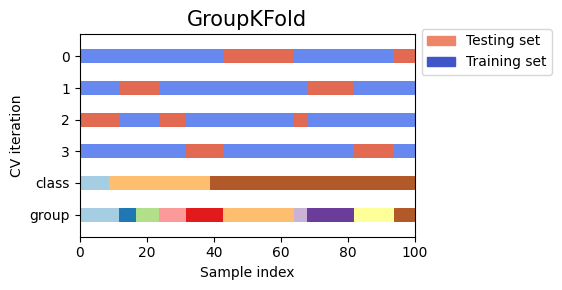

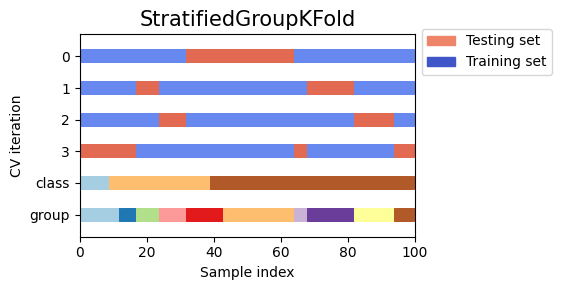

In [6]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

Ensuite, nous allons visualiser ce comportement pour un certain nombre d'itérateurs de CV.

# Visualiser les indices de validation croisée pour de nombreux objets CV

Comparons visuellement le comportement de validation croisée pour de nombreux objets de validation croisée scikit-learn. Ci-dessous, nous allons parcourir plusieurs objets de validation croisée courants, en visualisant le comportement de chacun.

Notez comment certains utilisent les informations de groupe/classe tandis que d'autres ne le font pas.

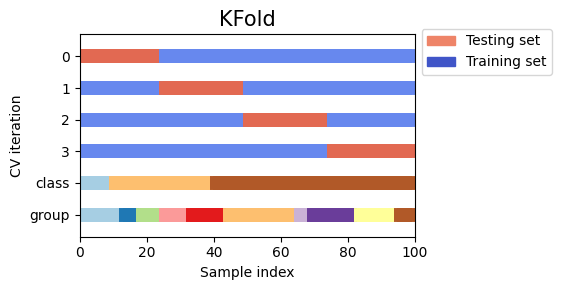

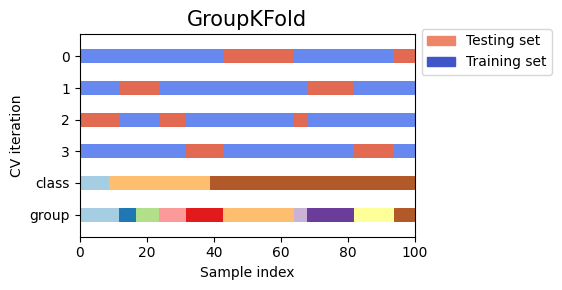

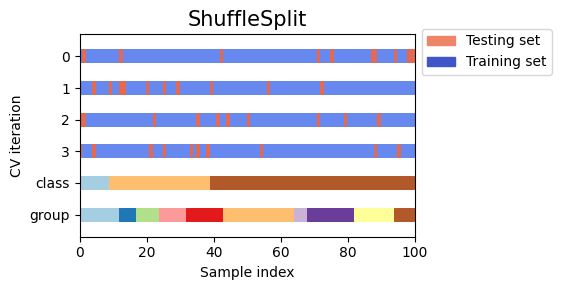

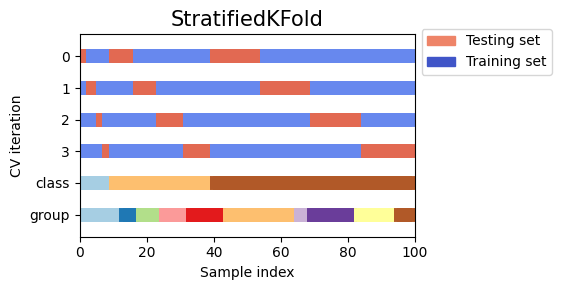

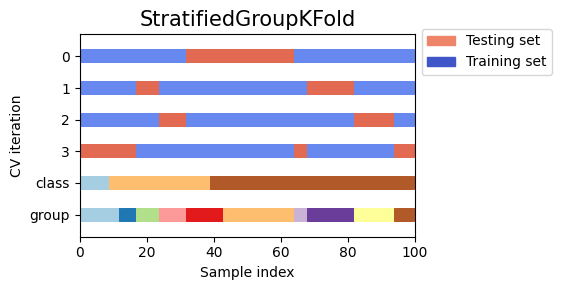

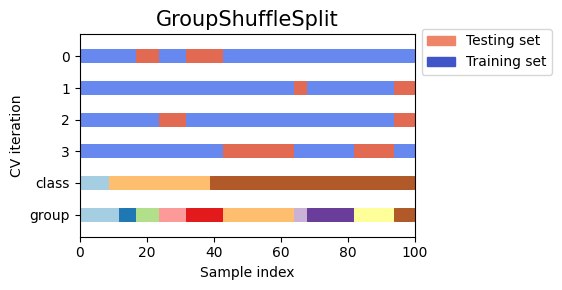

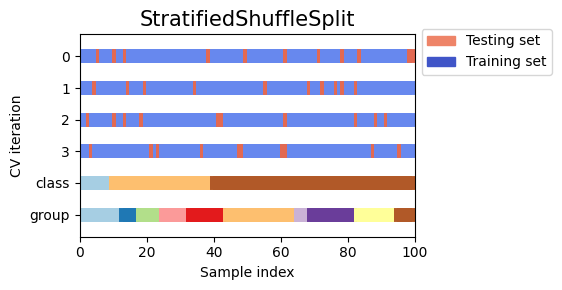

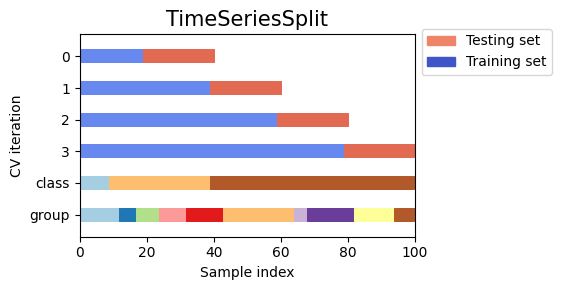

In [7]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()